### MBL engine:

The Hamiltonian of the given problem,
\begin{equation}
H = (1-\alpha_t)h\sigma^x + \alpha_t h' \sigma^z,
\end{equation}

where, $\alpha_t = e^{-t/\tau}$.

At,
t=0, $H(t=0) = h'\sigma^z$.

$t = \infty$, $H(t=\infty) = h\sigma^x$ .

Here, $h=\frac{\delta_{GOE}}{2}$, and  $h=\frac{\delta_{MBL}}{2}$; $\delta_{GOE}\gg \delta_{MBL}$.

Consider, $\tau \gg 1$.

We consider, the initial condition,

\begin{equation}
\hat{\rho} = \pmatrix{0.5 & o.5\\
                0.5 & 0.5}
\end{equation}

In quantum thermodynamics, the heat and work absorbed expressed as,

\begin{align}
W =& \int_0^\tau dt Tr\Bigg({\rho \frac{dH}{dt}}\Bigg)\\
Q =& \int_0^\tau dt Tr\Bigg({ \frac{d \rho}{dt}}H\Bigg)
\end{align}
This Q definition is narrower than the definition prevalent in the MBL. Here, all energy exchanged during unitary evolution counts as work.

We recall Liioville equation,

\begin{equation}
\frac{\partial\rho}{\partial t} = \frac{1}{i\hslash}[H, \rho] = \frac{i}{\hslash}[\rho,H] =i[\rho,H],
\end{equation}.

When applied to expectation value of an observable, the corresponding equation is given by Ehrenfest's theorem, and takes the form,
\begin{equation}
\frac{d}{dt}\langle A \rangle = -\frac{1}{i\hslash}\langle[H, A]\rangle = -i \langle[A,H]\rangle,
\end{equation}
where A is an observable and considering $\hslash =1$. Note the sign difference, which follows from the assumption that the operator is stationary and the state is time-dependent. 

Lets find the heat and workdone,

Heat,
\begin{align}
Q =& \int_0^\tau dt Tr\Bigg({ \frac{d \rho}{dt}}H\Bigg)\\
=& i\int_0^\tau dt Tr\Bigg(\big[\rho, H\big]H\Bigg)\\
Q=& i\int_0^\tau dt \langle [\rho, H]\rangle
\end{align}
Workdone,
\begin{align}
W =& \int_0^\tau dt Tr\Bigg({\rho \frac{dH}{dt}}\Bigg)\\
=& \int_0^\tau dt \Big\langle \frac{dH}{dt} \Big\rangle
\end{align},

Now, the given Hamilatonian is,
\begin{equation}
H = (1-\alpha_t)h\sigma^x + \alpha_t h' \sigma^z.
\end{equation}

And corresponding,
\begin{equation}
\frac{dH}{dt} =H'= -\alpha'_t h\sigma^x + \alpha'_t h' \sigma^z,
\end{equation}
where $\alpha'_t = -\frac{1}{\tau} e^{-t/\tau}$.

Now, $W+Q = \int_0^\tau Tr\Big(\frac{d}{dt}(\rho, H)\Big)= \langle H\rangle_{t=\tau}- \langle H\rangle_{t=0}$.

Also,

\begin{align}
Q=& \Big[\langle H\rangle_{t=\tau}- \langle H\rangle_{t=0}\Big] - \int_0^\tau dt \Big\langle\frac{dH}{dt}\Big\rangle.
\end{align}

ref:
[1].https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.024203

Running...
Simulation complete.

Calculating Parameters...


16it [01:31,  5.70s/it]


Now plotting ...


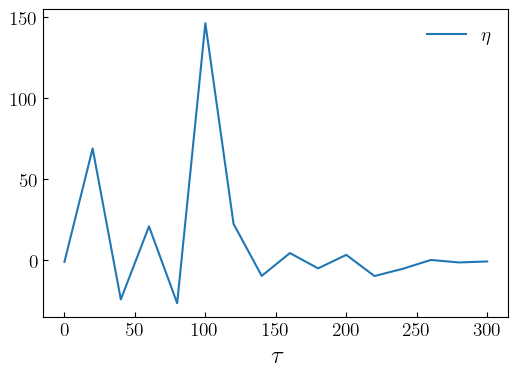

CPU times: user 1min 36s, sys: 522 ms, total: 1min 36s
Wall time: 1min 48s


In [1]:
%%time
from qutip import mesolve, qeye, Qobj, sigmax, sigmaz, Options
import numpy as np
from scipy.integrate import trapz, simps
from multiprocessing import Pool
import matplotlib.pyplot as plt
from tqdm import tqdm
from qutip.ui.progressbar import BaseProgressBar, TextProgressBar

plt.rcParams.update({
    "figure.figsize": (6,4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 14,"font.sans-serif": ["Computer Modern"]})

def ft(t, args):
    tau = args['tau']
    return np.exp(-t/tau)

def f1t(t, args):
    tau = args['tau']
    return -1/tau * np.exp(-t/tau)

def get_rhos(rho0, tau, args):
    H = args['H']    
    times = np.linspace(0,50000,10000)
    params = {'tau':tau} 
    rhos = mesolve(H, rho0, times, [], [], args = params)    
    return rhos.states

# Initial parameters
rho0 = Qobj(0.5 * np.ones((2,2)))
#rho0 = qeye(2)

h = 1
h1 = 0.1
taus = np.linspace(0.1,300,16)

H0 = h * sigmax() 
H1 = -h*sigmax() + h1 * sigmaz()
H = [H0, [H1, ft]]
dhdt = -h*sigmax() + h1*sigmaz()

opts = Options(nsteps=1e4)
nprocs = 8
p = Pool(processes = nprocs)
params = {'H':H,'opts':opts} 

print('Running...')
data = np.array(p.starmap(get_rhos,[(rho0,tau,params) for tau in taus]))

print('Simulation complete.\n\nCalculating Parameters...')

Qs, etas = [], []

for tt,tau in tqdm(enumerate(taus)):
    rhos = data[tt]
    times = np.linspace(0,50000,10000)
    
    params = {'tau':tau}     
    H_avgs = np.array([Qobj(np.array(rhos[i] * (H0 + H1*ft(t,params)))).tr() for i,t in enumerate(times)])
    dhdt_avg = np.array([Qobj(np.array(rhos[i] * (dhdt * f1t(t,params)))).tr() for i,t in enumerate(times)])
    
    total = H_avgs[-1]-H_avgs[0]
    W = trapz(dhdt_avg, times)
    Q = total - W
    eta = W/Q
    Qs.append(Q)
    etas.append(eta)
    
print('Now plotting ...')

#plt.plot(taus, Qs, label=r'$Q$')    
plt.plot(taus, etas, label=r'$\eta$')   
plt.xlabel(r'$\tau$',fontsize=18)
#plt.ylabel(r'$\eta$')
#plt.ylabel(r'$Q$')

plt.tick_params(which='both',axis="x", direction="in")
plt.tick_params(which='both',axis="y", direction="in")
plt.legend(frameon =False)
plt.show()

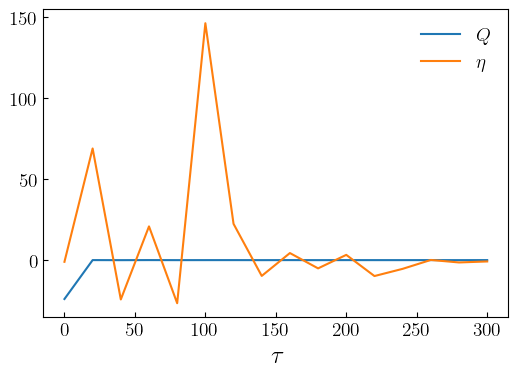

In [2]:
plt.plot(taus, Qs, label=r'$Q$')    
plt.plot(taus, etas, label=r'$\eta$')   
plt.xlabel(r'$\tau$',fontsize=18)
#plt.ylabel(r'$\eta$')
#plt.ylabel(r'$Q$')

plt.tick_params(which='both',axis="x", direction="in")
plt.tick_params(which='both',axis="y", direction="in")
plt.legend(frameon =False)
plt.show()

Now run with equation 32 in Halpern's paper

In [ ]:
%%time
from qutip import mesolve, qeye, Qobj, sigmax, sigmaz, Options
import numpy as np
from scipy.integrate import trapz, simps
from multiprocessing import Pool
import matplotlib.pyplot as plt
from tqdm import tqdm
from qutip.ui.progressbar import BaseProgressBar, TextProgressBar

plt.rcParams.update({
    "figure.figsize": (6,4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 14,"font.sans-serif": ["Computer Modern"]})

def ft(t, args):
    tau = args['tau']
    return np.exp(-t/tau)

def f1t(t, args):
    tau = args['tau']
    return -1/tau * np.exp(-t/tau)

def get_rhos(rho0, tau, args):
    H = args['H']    
    times = np.linspace(0,50000,10000)
    params = {'tau':tau} 
    rhos = mesolve(H, rho0, times, [], [], args = params)    
    return rhos.states

def hamiltonian(t, args):
    tau = args['tau']
    N = args['N']
    h = 1
    h1 = 0.1
    empt = qzero(2**N) + 1j * qzero(2**N)
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    H01, H02, H03, H1 = empt, empt, empt, empt
    
    for i in range(N-1):
        id = qeye(2**i)    
        dim11 = N-2-i
        id1 = qeye(2**dim11)
        H01 = H01 + Qobj(tensor(id,tensor(sx,tensor(sx,id1))).full())
        
    for i in range(N-1):
        id = qeye(2**i)    
        dim11 = N-2-i
        id1 = qeye(2**dim11)
        H02 = H02 + Qobj(tensor(id,tensor(sy,tensor(sy,id1))).full())
        
    for i in range(N-1):
        id = qeye(2**i)    
        dim11 = N-2-i
        id1 = qeye(2**dim11)
        H03 = H03 + Qobj(tensor(id,tensor(sz,tensor(sz,id1))).full())
    
    
    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H1 = H1 + np.random.uniform(-1,1) *  Qobj(tensor(id,tensor(sz,id1)).full())
        
    H0 = H01 + H02 + H03
    H1 = halpha(t,args) *  H1
    return H01, H02, H03, H1

def halpha(t, args):
    alpha = args['alpha']
    hgoe = args['hgoe']
    hmbl = args['hmbl']
    return alpha * hgoe + (1-alpha) * hmbl

# Initial parameters
rho0 = Qobj(0.5 * np.ones((2,2)))
#rho0 = qeye(2)

h = 1
h1 = 0.1
taus = np.linspace(0.1,300,16)
hgoe = 1
hmbl = 0.1

#H0 = h * sigmax() 
#H1 = -h*sigmax() + h1 * sigmaz()

H0, H1, H2, H3 = hamiltonian({'N':2})

H = [H0, [H1, ft]]
dhdt = -h*sigmax() + h1*sigmaz()

opts = Options(nsteps=1e4)
nprocs = 8
p = Pool(processes = nprocs)
params = {'H':H,'opts':opts, 'alpha':0.1, 'hgoe':hgoe, 'hmbl':hmbl}

# Write code from here...

print('Running...')
data = np.array(p.starmap(get_rhos,[(rho0,tau,params) for tau in taus]))

print('Simulation complete.\n\nCalculating Parameters...')

Qs, etas = [], []

for tt,tau in tqdm(enumerate(taus)):
    rhos = data[tt]
    times = np.linspace(0,50000,10000)
    
    params = {'tau':tau}     
    H_avgs = np.array([Qobj(np.array(rhos[i] * (H0 + H1*ft(t,params)))).tr() for i,t in enumerate(times)])
    dhdt_avg = np.array([Qobj(np.array(rhos[i] * (dhdt * f1t(t,params)))).tr() for i,t in enumerate(times)])
    
    total = H_avgs[-1]-H_avgs[0]
    W = trapz(dhdt_avg, times)
    Q = total - W
    eta = W/Q
    Qs.append(Q)
    etas.append(eta)
    
print('Now plotting ...')

#plt.plot(taus, Qs, label=r'$Q$')    
plt.plot(taus, etas, label=r'$\eta$')   
plt.xlabel(r'$\tau$',fontsize=18)
#plt.ylabel(r'$\eta$')
#plt.ylabel(r'$Q$')

plt.tick_params(which='both',axis="x", direction="in")
plt.tick_params(which='both',axis="y", direction="in")
plt.legend(frameon =False)
plt.show()